In [2]:
import fastPAT as fpat
import Load_PAT2D_data as data
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import Framework as fr
import odl
import numpy as np

In [3]:
frame = fr.framework()

Start loading test data
(256, 64, 64)
(256, 64, 64)
(256, 64, 64)
Start loading training data
(4096, 64, 64)
(4096, 64, 64)
(4096, 64, 64)
(64, 127)
(64, 127)
(64, 127)
(128, 64)
(128, 64)
(128, 64)
INFO:tensorflow:Restoring parameters from /local/scratch/public/sl767/ModelCorrection/Saves/balls64/default_experiment/Data/model-41100
Save restored


In [4]:
model = frame.pat_operator
pat_odl = fr.as_odl_operator(model)
cor_odl = fr.as_odl_operator(frame.cor_operator)
joint_odl = fr.as_odl_operator(fr.concat(frame.cor_operator, model))

In [5]:
dataApr, dataTrue, imageTrue = frame.data_sets.test.next_batch(1)

def tv_reconstruction(y, start_point, operator, param=0.0, steps = 1, o_norm = 20):
    space = operator.domain
    ran = operator.range
    # the operators
    gradients = odl.Gradient(space, method='forward')
    broad_op = odl.BroadcastOperator(operator, gradients)
    # define empty functional to fit the chambolle_pock framework
    g = odl.solvers.ZeroFunctional(broad_op.domain)

    # the norms
    l1_norm = param * odl.solvers.L1Norm(gradients.range)
    l2_norm_squared = odl.solvers.L2NormSquared(ran).translated(y)
    functional = odl.solvers.SeparableSum(l2_norm_squared, l1_norm)
    
    # hard code operator norm in, assuming the operator is roughy unitary
    op_norm = o_norm
    
    tau = 5.0 / op_norm
    sigma = 0.2 / op_norm
    niter = steps

    # find starting point
    s = np.copy(start_point)
    x = space.element(s)

    # Run the optimization algoritm
    # odl.solvers.chambolle_pock_solver(x, functional, g, broad_op, tau = tau, sigma = sigma, niter=niter)
    odl.solvers.pdhg(x, functional, g, broad_op, tau=tau, sigma=sigma, niter=niter)
    return x

def tv_reconstruction_positiv(y, start_point, operator, param=0.0, steps = 1, o_norm = 20):
    space = operator.domain
    ran = operator.range
    # the operators
    gradients = odl.Gradient(space, method='forward')
    broad_op = odl.BroadcastOperator(operator, gradients)
    # define empty functional to fit the chambolle_pock framework
    g = odl.solvers.IndicatorNonnegativity(space)

    # the norms
    l1_norm = param * odl.solvers.L1Norm(gradients.range)
    l2_norm_squared = odl.solvers.L2NormSquared(ran).translated(y)
    functional = odl.solvers.SeparableSum(l2_norm_squared, l1_norm)
    
    # hard code operator norm in, assuming the operator is roughy unitary
    op_norm = o_norm
    
    tau = 5.0 / op_norm
    sigma = 0.2 / op_norm
    niter = steps

    # find starting point
    s = np.copy(start_point)
    x = space.element(s)

    # Run the optimization algoritm
    # odl.solvers.chambolle_pock_solver(x, functional, g, broad_op, tau = tau, sigma = sigma, niter=niter)
    odl.solvers.pdhg(x, functional, g, broad_op, tau=tau, sigma=sigma, niter=niter)
    return x

def l2(x1,x2):
    return np.sum(np.square(x1 -x2))
                  
def data_error(image, measurement):
    return l2(model.evaluate(image)-measurement)

def data_error_cor(image, measurement):
    return l2(frame.cor_operator.evaluate(model.evaluate(image)-measurement))

def visualize(image, true_meas):
    meas = model.evaluate(image)
    cor_meas = frame.cor_operator.evaluate(meas)
    plt.figure()
    plt.subplot(141)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Reconstruction')
    plt.subplot(142)
    plt.imshow(meas)
    plt.axis('off')
    plt.title('Appr. y')
    plt.subplot(143)
    plt.imshow(cor_meas)
    plt.axis('off')
    plt.title('Cor. y')
    plt.subplot(144)
    plt.imshow(true_meas)
    plt.title('True y')
    plt.axis('off')
    plt.show()
    print('Data Error Uncorrected: {}'.format(l2(true_meas, meas)))
    print('Data Error Corrected: {}'.format(l2(true_meas, cor_meas)))

naive_inverse = model.inverse(dataTrue[0,...])
x = tv_reconstruction(dataTrue[0,...], start_point=naive_inverse, operator=pat_odl)

True Image


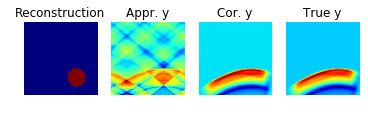

Data Error Uncorrected: 8.08352418413
Data Error Corrected: 0.0246172459737


In [6]:
print('True Image')
visualize(imageTrue[0,...], dataTrue[0,...])

Direct Inverse


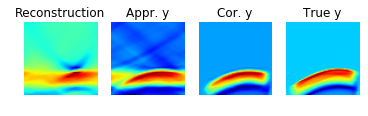

Data Error Uncorrected: 3.49296234688
Data Error Corrected: 2.39674186759


In [7]:
print('Direct Inverse')
visualize(naive_inverse, dataTrue[0,...])

Minimizer Uncorrected data term, no TV, positivity constraint


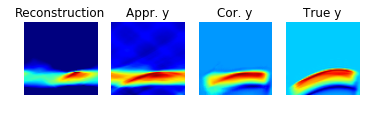

Data Error Uncorrected: 3.92554597513
Data Error Corrected: 3.39771038653


In [8]:
steps = 50
rec = tv_reconstruction_positiv(dataTrue[0,...], start_point=naive_inverse, operator=pat_odl, steps=steps, param = 0.0)
print('Minimizer Uncorrected data term, no TV, positivity constraint')
visualize(rec, dataTrue[0,...])

Minimizer Uncorrected data term, no TV


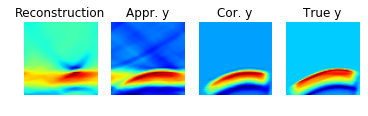

Data Error Uncorrected: 3.4832610424
Data Error Corrected: 2.39246773001


In [9]:
steps = 50
rec = tv_reconstruction(dataTrue[0,...], start_point=naive_inverse, operator=pat_odl, steps=steps, param = 0.0)
print('Minimizer Uncorrected data term, no TV')
visualize(rec, dataTrue[0,...])

TV, uncorrected operator, positivity constraint


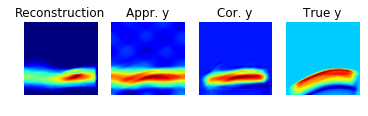

Data Error Uncorrected: 4.28762391375
Data Error Corrected: 4.42653714182


In [10]:
steps = 50
rec2 = tv_reconstruction_positiv(dataTrue[0,...], start_point=naive_inverse, operator=pat_odl, steps=steps, param = 0.05)
print('TV, uncorrected operator, positivity constraint')
visualize(rec2, dataTrue[0,...])

TV, corrected operator


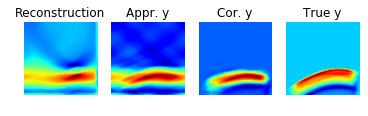

Data Error Uncorrected: 4.18094353802
Data Error Corrected: 4.22669406525


In [11]:
steps = 50
rec3 = tv_reconstruction(dataTrue[0,...], start_point=naive_inverse, 
                         operator=cor_odl*pat_odl, steps=steps, param = 0.05)
print('TV, corrected operator')
visualize(rec3, dataTrue[0,...])

TV, corrected operator, positivity constraint


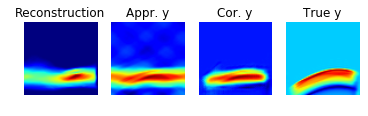

Data Error Uncorrected: 4.28749778215
Data Error Corrected: 4.42399127356


In [12]:
steps = 50
rec3 = tv_reconstruction_positiv(dataTrue[0,...], start_point=naive_inverse, 
                         operator=cor_odl*pat_odl, steps=steps, param = 0.05)
print('TV, corrected operator, positivity constraint')
visualize(rec3, dataTrue[0,...])